#Atividade: Tradução Automática

## Import das depedencias

In [2]:
!pip install mxnet

In [3]:
!pip install d2l

In [4]:
import os
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

## Download e pré-processamento do conjunto de dados do Projeto Tatoeba

In [5]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [6]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## Tokenização

In [23]:
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['hello', 'how', 'are', 'you?'],
  ['i', 'am', 'fine,', 'thank', 'you'],
  ['what', 'is', 'your', 'name?'],
  ['my', 'name', 'is', 'John'],
  ['see', 'you', 'tomorrow'],
  ['good', 'morning']],
 [['bonjour', 'comment', 'ça', 'va', '?'],
  ['je', 'vais', 'bien,', 'merci'],
  ['comment', 'tu', "t'appelles", '?'],
  ['je', "m'appelle", 'John'],
  ['à', 'demain'],
  ['bonjour']])

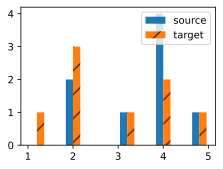

In [24]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

## Vocabulário

In [25]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

7

##  Carregando o Conjunto de Dados

In [26]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3, 3, 3, 3, 2, 2, 2, 2, 2, 2]

In [27]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).astype(np.int32).sum(1)
    return array, valid_len

## Load data

In [28]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [29]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.astype(np.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.astype(np.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: [[ 45 155   2   4   5   5   5   5]
 [ 67   0   4   5   5   5   5   5]]
valid lengths for X: [4 3]
Y: [[182 198   0   4   5   5   5   5]
 [  6   0   4   5   5   5   5   5]]
valid lengths for Y: [4 3]


## Exercícios

1. Tente valores diferentes do argumento num_examples na funçãoload_data_nmt. Como isso afeta os tamanhos do vocabulário do idioma de origem e do idioma de destino?




- num_examples pequeno: Se num_examples for pequeno, a função vai processar poucas linhas do dataset, o que significa que o número de palavras únicas (vocabulário) será limitado. Quanto menos exemplos, menor o vocabulário tanto na língua de origem quanto na de destino.

- num_examples grande ou não especificado: À medida que aumenta o valor de num_examples, ou não define um valor (processando o dataset inteiro), mais frases serão incluídas no processamento. Isso aumentará o vocabulário, pois novas palavras serão encontradas em mais exemplos. Dessa forma, o vocabulário de origem e destino será maior.

### Exemplo

In [15]:
# Função tokenize_nmt já definida
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

# Função para contar vocabulário
def count_vocab(tokenized_data):
    vocab = set()
    for sentence in tokenized_data:
        vocab.update(sentence)  # Adiciona cada palavra ao conjunto (garantindo unicidade)
    return len(vocab)  # Retorna o número de palavras únicas

# Carregar o dataset de exemplo
text = """
hello how are you?\tbonjour comment ça va ?
i am fine, thank you\tje vais bien, merci
what is your name?\tcomment tu t'appelles ?
my name is John\tje m'appelle John
see you tomorrow\tà demain
good morning\tbonjour
have a nice day\tbonne journée
good night\tbonne nuit
"""

# Testando com diferentes valores de num_examples
for examples in [2, 4, 6, None]:
    source, target = tokenize_nmt(text, num_examples=examples)
    source_vocab_size = count_vocab(source)
    target_vocab_size = count_vocab(target)

    print(f"Num examples: {examples}")
    print(f"Source vocab size: {source_vocab_size}")
    print(f"Target vocab size: {target_vocab_size}\n")


Num examples: 2
Source vocab size: 9
Target vocab size: 9

Num examples: 4
Source vocab size: 16
Target vocab size: 13

Num examples: 6
Source vocab size: 20
Target vocab size: 15

Num examples: None
Source vocab size: 25
Target vocab size: 18



2. O texto em alguns idiomas, como chinês e japonês, não tem indicadores de limite de palavras (por exemplo, espaço). A tokenização em nível de palavra ainda é uma boa ideia para esses casos? Por que ou por que não?

 A tokenização em nível de palavra não é a melhor abordagem para chinês e japonês, pois esses idiomas não possuem delimitadores de palavras explícitos, como espaços entre as palavras. Um único bloco de texto pode conter várias palavras, mas sem delimitação explícita entre elas, o que torna difícil identificar os limites das palavras de forma direta. Sem espaços, pode haver ambiguidade ao tentar separar palavras.